# **Credit Risk Prediction: Analyzing Loan Applicant Risk Based on Demographic and Financial Attributes**

### **1. Imports**

In [2]:
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### **2. Summary**

This project aims to develop a predictive model to assess the credit risk of loan applicants using the Statlog (German Credit Data) dataset. The primary objective is to determine whether an applicant is a good or bad credit risk based on various demographic and financial attributes. We explored a few models and landed on a Random Forest classifier as it had the highest accuracy and was also able to minimize false negatives, which is crucial for reducing the risk of approving applicants with poor creditworthiness.


### **3. Introduction**
#### **Background**
Credit risk assessment is a crucial process in banking and financial services. Lenders evaluate borrowers based on financial stability and past credit behavior to determine their likelihood of defaulting on a loan. With the advancements in machine learning, automated credit risk assessment has gained traction as it can efficiently analyze large datasets, identify risk patterns, and improve lending decisions. This project explores whether a machine learning model can predict whether a loan applicant is a good or bad credit risk based on demographic and financial data.  

#### **Research Question**
Can we classify a loan applicant as a **good** or **bad** credit risk using a combination of **demographic, financial, and loan-specific attributes**?  

#### **Dataset: German Credit Data**
The dataset used in this analysis is the **German Credit Dataset**, originally compiled by **Professor Dr. Hans Hofmann** from **Universität Hamburg**. It contains 1,000 instances with 20 attributes describing various aspects of a loan applicant's financial and personal profile. The dataset has both categorical and numerical attributes and provides a labeled classification of good vs. bad credit risk.

##### **Target Variable (Credit Standing)**
- **0** → Good Credit Risk (low risk, likely to repay)
- **1** → Bad Credit Risk (high risk, potential default)

##### **Key Features**
The dataset consists of three broad categories of features:

1. **Demographic Information:**
   - **Age** (numerical): The applicant’s age in years.
   - **Employment Status** (categorical): The applicant’s work experience categorized into different groups.
   - **Foreign Worker Status** (categorical): Whether the applicant is a foreign worker (Yes/No).
   - **Personal Status & Gender** (categorical): Applicant’s marital status and gender.

2. **Financial Attributes:**
   - **Credit History** (categorical): Previous credit behavior (e.g., no previous credit, delayed payments, fully repaid).
   - **Status of Checking Account** (categorical): Information on the applicant’s checking account balance.
   - **Savings Account/Bonds** (categorical): Level of savings held by the applicant.
   - **Credit Amount** (numerical): The total loan amount requested.
   - **Other Debtors/Guarantors** (categorical): Whether the applicant has co-applicants or guarantors.

3. **Loan & Payment Behavior:**
   - **Loan Purpose** (categorical): The purpose for which the loan is requested (e.g., car, education, business).
   - **Loan Duration (Months)** (numerical): The length of the loan term.
   - **Installment Rate** (numerical): Loan repayment amount as a percentage of disposable income.
   - **Existing Credits at Bank** (numerical): The number of current outstanding loans with the bank.
   - **Other Installment Plans** (categorical): Whether the applicant has other loans with banks or stores.
   - **Housing Status** (categorical): Whether the applicant owns, rents, or lives rent-free.

### **3. Methods & Results**

This section outlines the step-by-step methodology used to preprocess the dataset, perform exploratory data analysis (EDA), and build machine learning models for credit risk classification.


#### **3.1 Data Preprocessing**
##### **Loading and Cleaning the Data**
- The dataset was loaded from a **CSV file** into a Jupyter Notebook.
- Column names were **added to the dataset** for readability.
- **Ambiguous categorical feature names** were mapped to **interpretable labels** for improved understanding.

In [3]:
file_path = "data/german.data"

df = pd.read_csv(file_path, sep=" ", header=None)

print(df.head())

    0   1    2    3     4    5    6   7    8     9   ...    11  12    13  \
0  A11   6  A34  A43  1169  A65  A75   4  A93  A101  ...  A121  67  A143   
1  A12  48  A32  A43  5951  A61  A73   2  A92  A101  ...  A121  22  A143   
2  A14  12  A34  A46  2096  A61  A74   2  A93  A101  ...  A121  49  A143   
3  A11  42  A32  A42  7882  A61  A74   2  A93  A103  ...  A122  45  A143   
4  A11  24  A33  A40  4870  A61  A73   3  A93  A101  ...  A124  53  A143   

     14 15    16 17    18    19 20  
0  A152  2  A173  1  A192  A201  1  
1  A152  1  A173  1  A191  A201  2  
2  A152  1  A172  2  A191  A201  1  
3  A153  1  A173  2  A191  A201  1  
4  A153  2  A173  2  A191  A201  2  

[5 rows x 21 columns]


In [4]:
column_names = [
    "Checking_Acc_Status", "Duration (in months)", "Credit_History", "Purpose",
    "Credit_Amount", "Savings_Acc", "Employment", "Installment_Rate",
    "Personal_Status", "Other_Debtors", "Residence_Since", "Property",
    "Age", "Other_Installment", "Housing", "Existing_Credits",
    "Job", "Num_People_Maintained", "Telephone", "Foreign_Worker", "Credit Standing"
]
# Assign column names
df.columns = column_names

mappings = {
    "Checking_Acc_Status": {
        "A11": "< 0 DM",
        "A12": "0-200 DM",
        "A13": ">= 200 DM or Salary Assigned",
        "A14": "No Checking Account"
    },
    "Credit_History": {
        "A30": "No Credit Taken / All Paid",
        "A31": "All Paid (Same Bank)",
        "A32": "All Paid (Other Banks)",
        "A33": "Past Delays in Payment",
        "A34": "Critical Account / Other Existing Credits"
    },
    "Purpose": {
        "A40": "New Car",
        "A41": "Used Car",
        "A42": "Furniture/Equipment",
        "A43": "Radio/TV",
        "A44": "Domestic Appliances",
        "A45": "Repairs",
        "A46": "Education",
        "A47": "Vacation",
        "A48": "Retraining",
        "A49": "Business",
        "A410": "Others"
    },
    "Savings_Acc": {
        "A61": "< 100 DM",
        "A62": "100-500 DM",
        "A63": "500-1000 DM",
        "A64": ">= 1000 DM",
        "A65": "No Savings Account"
    },
    "Employment": {
        "A71": "Unemployed",
        "A72": "< 1 Year",
        "A73": "1-4 Years",
        "A74": "4-7 Years",
        "A75": ">= 7 Years"
    },
    "Personal_Status": {
        "A91": "Male: Divorced/Separated",
        "A92": "Female: Divorced/Separated/Married",
        "A93": "Male: Single",
        "A94": "Male: Married/Widowed",
        "A95": "Female: Single"
    },
    "Other_Debtors": {
        "A101": "None",
        "A102": "Co-applicant",
        "A103": "Guarantor"
    },
    "Property": {
        "A121": "Real Estate",
        "A122": "Building Society Savings / Life Insurance",
        "A123": "Car or Other Property",
        "A124": "No Property"
    },
    "Other_Installment": {
        "A141": "Bank",
        "A142": "Stores",
        "A143": "None"
    },
    "Housing": {
        "A151": "Rent",
        "A152": "Own",
        "A153": "For Free"
    },
    "Job": {
        "A171": "Unemployed / Unskilled (Non-Resident)",
        "A172": "Unskilled (Resident)",
        "A173": "Skilled Employee / Official",
        "A174": "Management / Self-Employed / Highly Qualified"
    },
    "Telephone": {
        "A191": "No Telephone",
        "A192": "Yes, Registered"
    },
    "Foreign_Worker": {
        "A201": "Yes",
        "A202": "No"
    }
}

for col, mapping in mappings.items():
    df[col] = df[col].map(mapping)

# Print updated DataFrame
print(df.head())

   Checking_Acc_Status  Duration (in months)  \
0               < 0 DM                     6   
1             0-200 DM                    48   
2  No Checking Account                    12   
3               < 0 DM                    42   
4               < 0 DM                    24   

                              Credit_History              Purpose  \
0  Critical Account / Other Existing Credits             Radio/TV   
1                     All Paid (Other Banks)             Radio/TV   
2  Critical Account / Other Existing Credits            Education   
3                     All Paid (Other Banks)  Furniture/Equipment   
4                     Past Delays in Payment              New Car   

   Credit_Amount         Savings_Acc  Employment  Installment_Rate  \
0           1169  No Savings Account  >= 7 Years                 4   
1           5951            < 100 DM   1-4 Years                 2   
2           2096            < 100 DM   4-7 Years                 2   
3           7882

In [5]:
# Convert categorical data to numerical format using one-hot encoding
df = pd.get_dummies(df, drop_first=True).astype(int)

# Map the 'Credit Standing' column from 1 (good) and 2 (bad) to 0 (good) and 1 (bad)
df['Credit Standing'] = df['Credit Standing'].map({1: 0, 2: 1})

# Ensure all categorical columns are encoded as 0s and 1s
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes

# Print updated DataFrame
print(df.head())

   Duration (in months)  Credit_Amount  Installment_Rate  Residence_Since  \
0                     6           1169                 4                4   
1                    48           5951                 2                2   
2                    12           2096                 2                3   
3                    42           7882                 2                4   
4                    24           4870                 3                4   

   Age  Existing_Credits  Num_People_Maintained  Credit Standing  \
0   67                 2                      1                0   
1   22                 1                      1                1   
2   49                 1                      2                0   
3   45                 1                      2                0   
4   53                 2                      2                1   

   Checking_Acc_Status_< 0 DM  \
0                           1   
1                           0   
2                           0

**Correlation Analysis**
Each numerical feature was examined for its correlation with **credit standing**.

| Feature                | Correlation with Credit Standing |
|------------------------|--------------------------------|
| **Checking Account Status (< 0 DM)** | **0.26** (Strongest correlation) |
| **Loan Duration (Months)**  | **0.21** |
| **Savings Account (< 100 DM)** | **0.16** |
| **Credit Amount**      | **0.15** |
| **Credit History (No Credit Taken / All Paid Back)** | **0.14** |
| **Employment (< 1 Year)** | **0.13** |
| **Property (No Property)** | **0.13** |
| **Housing (Renting)** | **0.09** |
| **Foreign Worker (Yes)** | **0.08** |
| **Installment Rate**   | **0.07** |
| **Age**               | **-0.09 (Negative correlation)** |

**Key Insights:**
- **Checking account status, loan duration, and credit amount are the strongest predictors** of credit standing.
- **Age has a weak negative correlation**, indicating that **younger borrowers are more likely to default**.
- **Property ownership and employment stability** also contribute to creditworthiness.


/var/folders/nk/xk4mj8ts0ps645l4yh1nyfmh0000gp/T/ipykernel_86885/1761696426.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index,


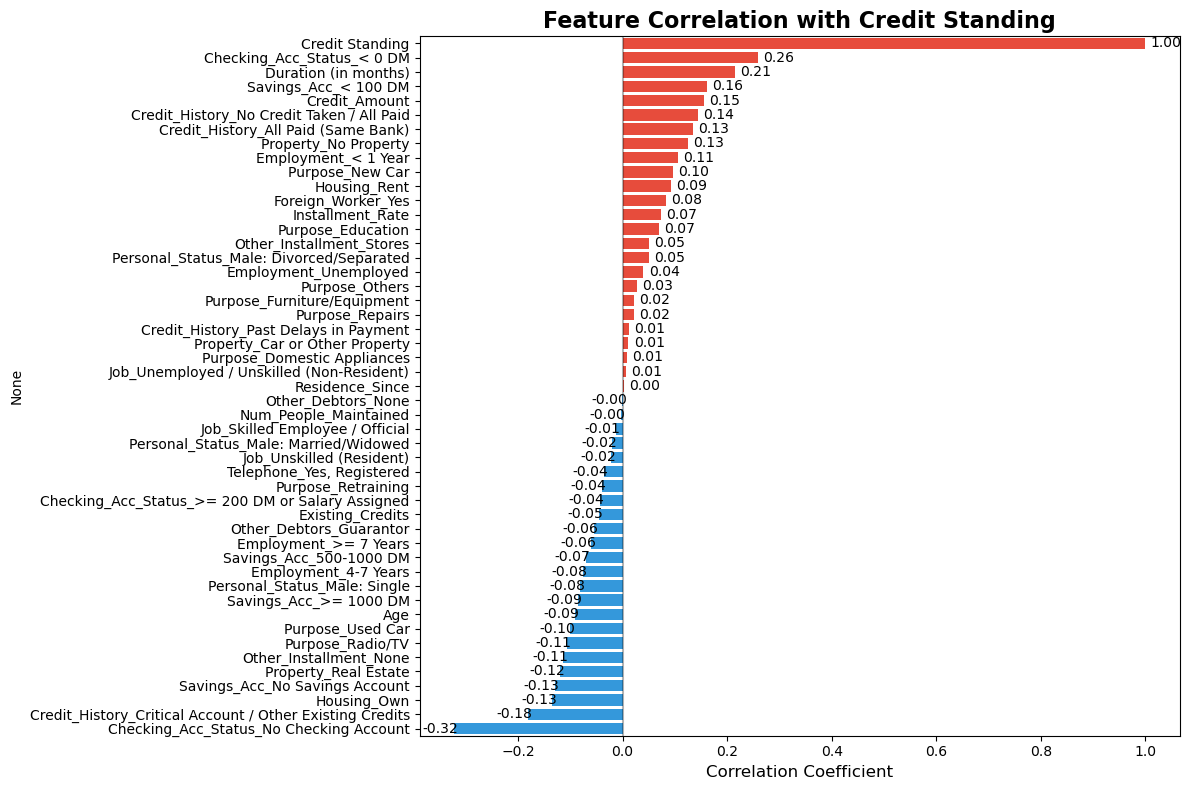

In [6]:
 # 1. Correlation analysis - Place this BEFORE one-hot encoding
# Select numerical columns for correlation analysis
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Calculate correlation with target
correlation_with_target = df[numerical_cols].corrwith(df['Credit Standing']).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
bars = sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, 
                  palette=sns.color_palette("RdBu_r", len(correlation_with_target)))

plt.title('Feature Correlation with Credit Standing', fontsize=16, fontweight='bold')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Color bars based on correlation value
for i, bar in enumerate(bars.patches):
    if correlation_with_target.values[i] > 0:
        bar.set_facecolor('#e74c3c')  # Red for positive correlation
    else:
        bar.set_facecolor('#3498db')  # Blue for negative correlation

# Add correlation values as text
for i, v in enumerate(correlation_with_target.values):
    plt.text(v + 0.01 if v >= 0 else v - 0.06, i, f'{v:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

 **Credit Standing Distribution**
The dataset contains **1,000 loan applicants**, categorized into **good credit (0) and bad credit (1)**:

- **70%** of applicants have **good credit standing**.
- **30%** have **bad credit standing**.

**Key Finding:**  
- The dataset is **imbalanced**, meaning a naive model predicting only "good credit" would still achieve **70% accuracy**.  
- A **balanced evaluation metric** (like F1-score) is necessary.

In [9]:

# Set a more appealing visual style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.edgecolor'] = '#333333'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.color'] = '#333333'
plt.rcParams['ytick.color'] = '#333333'

# Custom color palette
custom_palette = ['#3498db', '#e74c3c']
custom_cmap = sns.diverging_palette(220, 10, as_cmap=True)



/var/folders/nk/xk4mj8ts0ps645l4yh1nyfmh0000gp/T/ipykernel_86885/111392532.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=target_counts.index, y=target_counts.values, palette=custom_palette)


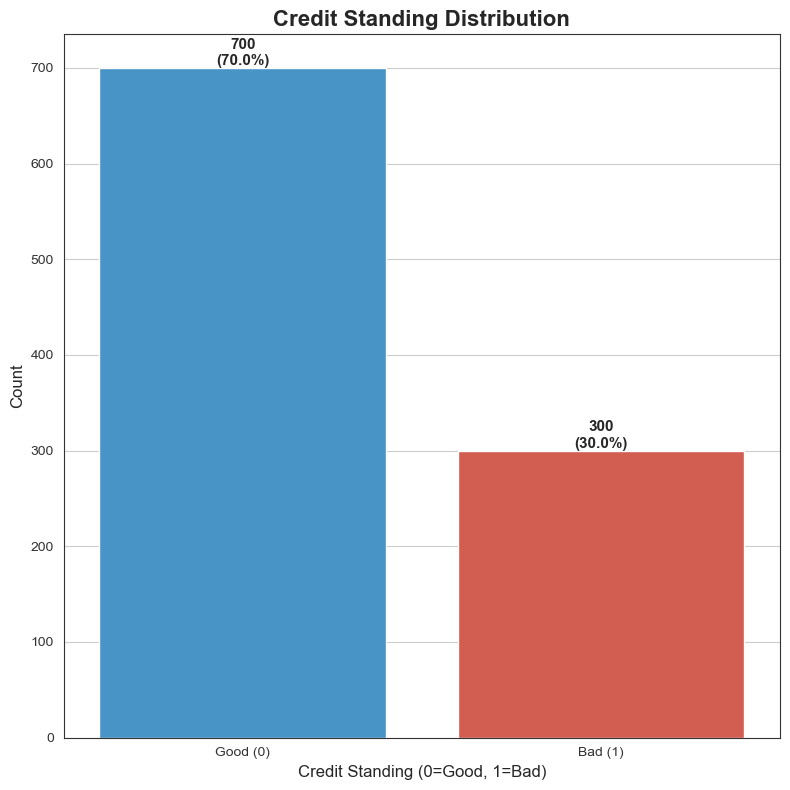

Good credits: 700 (70.00%)
Bad credits: 300 (30.00%)


In [10]:
# 1. Check class distribution in the target variable
plt.figure(figsize=(8, 8))
target_counts = df['Credit Standing'].value_counts()
ax = sns.barplot(x=target_counts.index, y=target_counts.values, palette=custom_palette)
plt.title('Credit Standing Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Credit Standing (0=Good, 1=Bad)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Good (0)', 'Bad (1)'], fontsize=10)

# Add percentage labels
total = len(df)
for i, p in enumerate(ax.patches):
    percentage = 100 * p.get_height() / total
    ax.annotate(f'{int(p.get_height())}\n({percentage:.1f}%)', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Good credits: {target_counts[0]} ({target_counts[0]/total*100:.2f}%)")
print(f"Bad credits: {target_counts[1]} ({target_counts[1]/total*100:.2f}%)")

### **Feature Distributions**
Key numerical features were analyzed to observe differences between **good and bad credit applicants**.

#### **Credit Amount Distribution**
_(See Figure 2)_
- **Good credit applicants** borrowed, on average, **~2,985 DM**.
- **Bad credit applicants** borrowed **~3,938 DM**, which is **~1,000 DM more**.
- The distribution is **right-skewed**, meaning a few applicants borrowed **significantly higher amounts**.

**Key Finding:**  
- Higher loan amounts are **associated with a higher likelihood of bad credit standing**.

#### **Age Distribution**
_(See Figure 3)_
- **Good credit applicants** had an **average age of 36.22 years**.
- **Bad credit applicants** had an **average age of 33.96 years**.
- The age distribution is **slightly right-skewed**, meaning there are **fewer older borrowers**.

**Key Finding:**  
- **Younger applicants** tend to have **worse credit standing**.
- Older applicants are slightly **less likely to default**.

#### **Loan Duration Distribution**
_(See Figure 4)_
- **Good credit applicants** held loans for **~19.21 months on average**.
- **Bad credit applicants** held loans for **~24.86 months on average**.
- **Longer loan durations correlate with a higher likelihood of bad credit.**

**Key Finding:**  
- Applicants with **longer loan durations** have a **higher risk of default**.

---

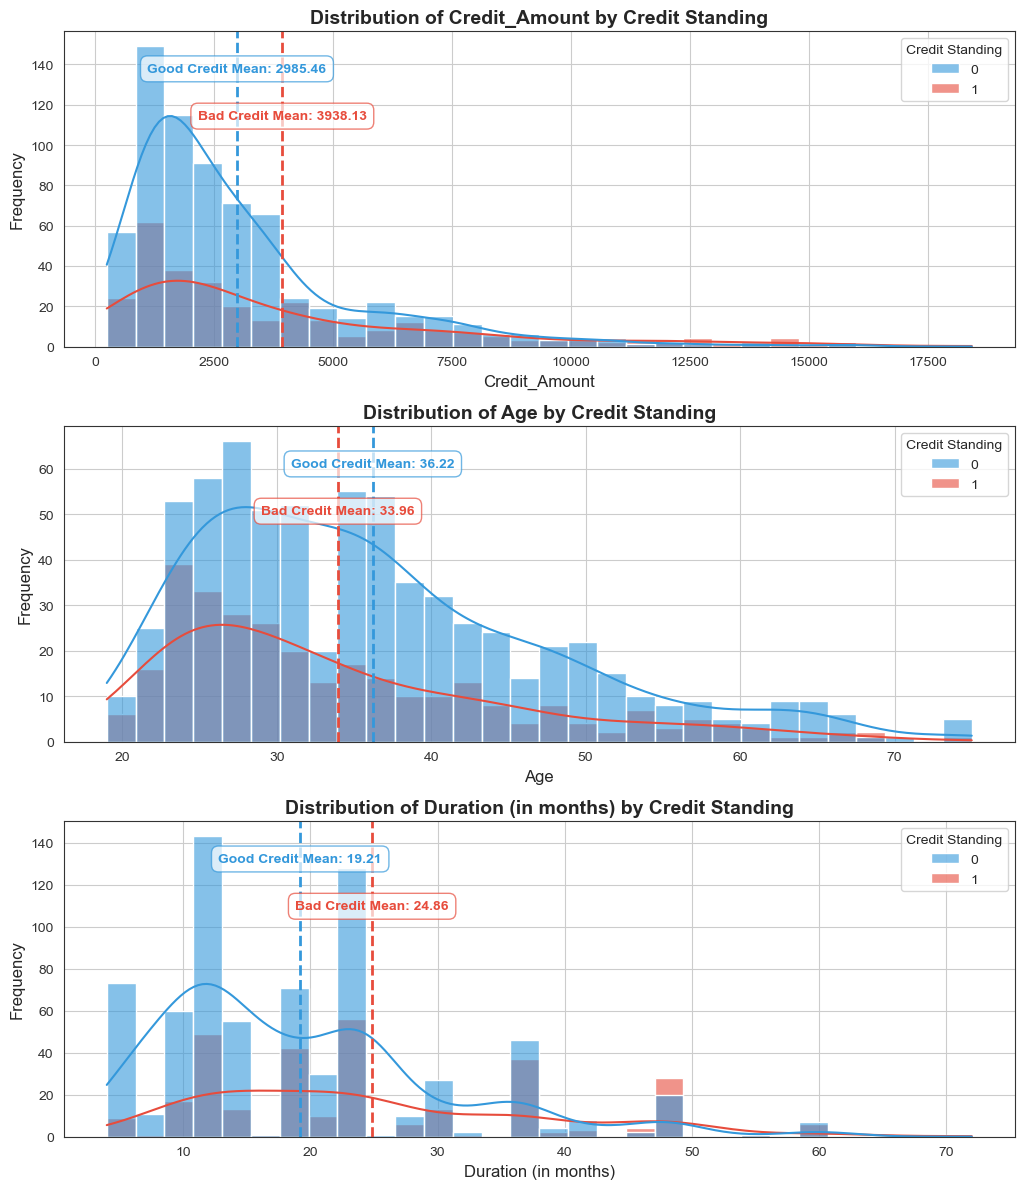

In [ ]:
# 3. Feature distributions
# Select top numerical features (based on correlation or importance)
top_features = ['Credit_Amount', 'Age', 'Duration (in months)']

fig, axes = plt.subplots(len(top_features), 1, figsize=(12, 4*len(top_features)))

for i, feature in enumerate(top_features):
    # Create KDE plot with histograms
    # Fix the order of hue levels to ensure correct color mapping
    sns.histplot(data=df, x=feature, hue='Credit Standing', kde=True, 
                 palette=custom_palette, alpha=0.6, bins=30, ax=axes[i],
                 hue_order=[0, 1])  # Explicitly set order: 0=Good, 1=Bad
    
    # Customize the plot
    axes[i].set_title(f'Distribution of {feature} by Credit Standing', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    
   
    # Add mean lines with non-overlapping labels
    for j, (credit_status, color, label) in enumerate(zip([0, 1], custom_palette, ['Good Credit', 'Bad Credit'])):
        subset = df[df['Credit Standing'] == credit_status]
        mean_val = subset[feature].mean()
        count = len(subset)
        percent = 100 * count / len(df)
        
        axes[i].axvline(x=mean_val, color=color, linestyle='--', linewidth=2)
        
        # Position labels at different heights to avoid overlap
        y_pos = axes[i].get_ylim()[1] * (0.9 - j*0.15)  # Stagger vertically
        
        # Add background to text for better readability
        axes[i].text(mean_val, y_pos, 
                     f'{label} Mean: {mean_val:.2f}', 
                     color=color, fontweight='bold', ha='center', va='top',
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor=color, boxstyle='round,pad=0.5'))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for legend
plt.show()

### **3.3 Model Performance Analysis**

To evaluate the effectiveness of different classification models for predicting credit standing, we tested three models:

1. **Baseline Model (Majority Class Classifier)**
2. **K-Nearest Neighbors (KNN) - Optimized**
3. **Random Forest - Optimized**

Each model was assessed based on **accuracy, precision, recall, and F1-score**, considering the **imbalance in the dataset**.

In [ ]:
# Separate features and target
X = df.drop('Credit Standing', axis=1)
y = df['Credit Standing']

# Create train-test split (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Scale features for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to evaluate and visualize model performance
def evaluate_model(model, X_test, y_test, model_name, scaled=False):
    # Use scaled data if required
    X_test_eval = X_test_scaled if scaled else X_test
    
    # Make predictions
    y_pred = model.predict(X_test_eval)
    y_pred_proba = model.predict_proba(X_test_eval)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print metrics
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Good Credit', 'Bad Credit']))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Good Credit', 'Bad Credit'],
                yticklabels=['Good Credit', 'Bad Credit'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

##### **Baseline Model: Majority Class Classifier**

- The **baseline model** predicts all applicants as **Good Credit** (0), as 70% of the dataset belongs to this class.
- **Accuracy:** **70%** (since it predicts the majority class correctly)
- **Precision, Recall, and F1-score for Bad Credit (1):** **0.00** 


Baseline (Majority Class) Performance:
Accuracy: 0.7000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.5000

Classification Report:
              precision    recall  f1-score   support

 Good Credit       0.70      1.00      0.82       175
  Bad Credit       0.00      0.00      0.00        75

    accuracy                           0.70       250
   macro avg       0.35      0.50      0.41       250
weighted avg       0.49      0.70      0.58       250



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/s

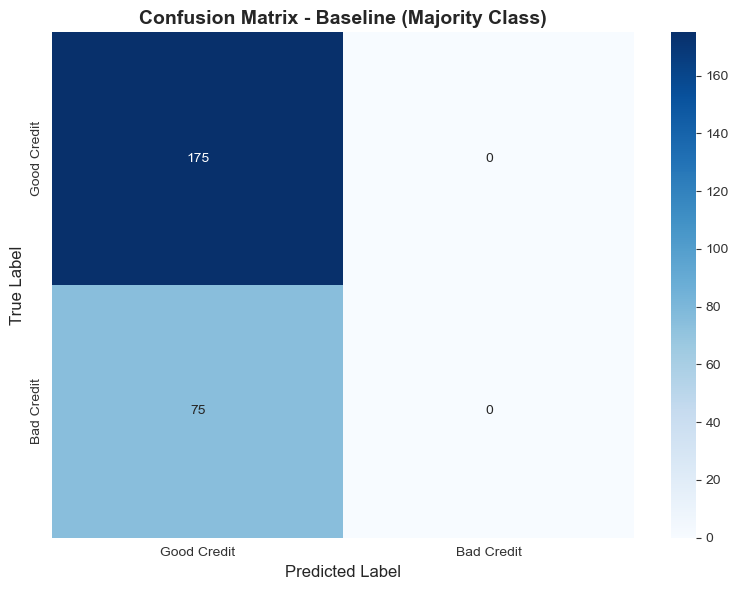

In [ ]:
# 1. Baseline Model (Majority Class Classifier)
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_train, y_train)
baseline_metrics = evaluate_model(baseline_model, X_test, y_test, "Baseline (Majority Class)")



**Key Takeaways:**
- The baseline model highlights the importance of **building a predictive model**, as it **completely fails to detect bad credit applicants**.
- **Misclassification Cost:** This model would **approve every bad credit applicant**, leading to financial losses.
 
 

##### **K-Nearest Neighbors (Optimized)**

- **Hyperparameter tuning (Grid Search) was used to optimize:**
  - **Distance Metric:** Manhattan
  - **Number of Neighbors (k):** 3
  - **Weighting:** Distance-based



Best KNN parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

KNN (Optimized) Performance:
Accuracy: 0.7280
Precision: 0.5593
Recall: 0.4400
F1 Score: 0.4925
ROC AUC: 0.7384

Classification Report:
              precision    recall  f1-score   support

 Good Credit       0.78      0.85      0.81       175
  Bad Credit       0.56      0.44      0.49        75

    accuracy                           0.73       250
   macro avg       0.67      0.65      0.65       250
weighted avg       0.71      0.73      0.72       250



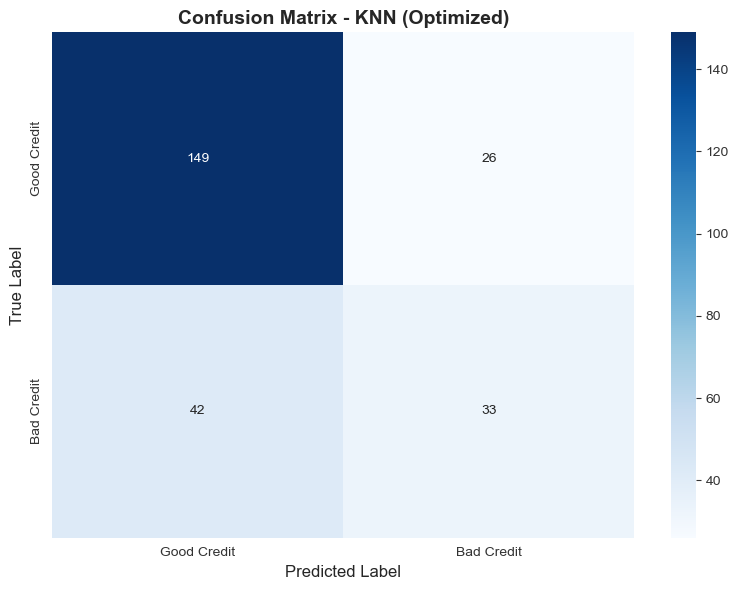

In [ ]:
# 2. KNN Classifier with Grid Search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest KNN parameters: {grid_search.best_params_}")
best_knn = grid_search.best_estimator_
knn_metrics = evaluate_model(best_knn, X_test, y_test, "KNN (Optimized)", scaled=True)



**Key Takeaways:**
- The KNN model shows **improvement over the baseline**.
- **Bad Credit Recall improved to 44%**, meaning the model **detects more defaulters**.
- However, **it still struggles with false positives and false negatives**.

##### **Random Forest (Optimized)**
_(See Figure 8: Confusion Matrix - Random Forest Model)_

- **Hyperparameter tuning (Grid Search) was used to optimize:**
  - **Class Weight:** Balanced
  - **Max Depth:** 20
  - **Min Samples per Split:** 10
  - **Number of Estimators:** 50




Best Random Forest parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 50}

Random Forest (Optimized) Performance:
Accuracy: 0.7840
Precision: 0.6567
Recall: 0.5867
F1 Score: 0.6197
ROC AUC: 0.7910

Classification Report:
              precision    recall  f1-score   support

 Good Credit       0.83      0.87      0.85       175
  Bad Credit       0.66      0.59      0.62        75

    accuracy                           0.78       250
   macro avg       0.74      0.73      0.73       250
weighted avg       0.78      0.78      0.78       250



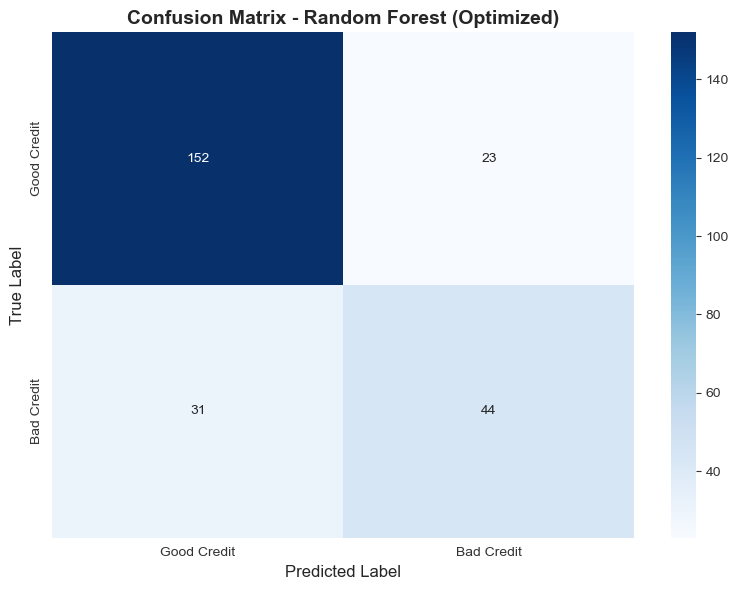

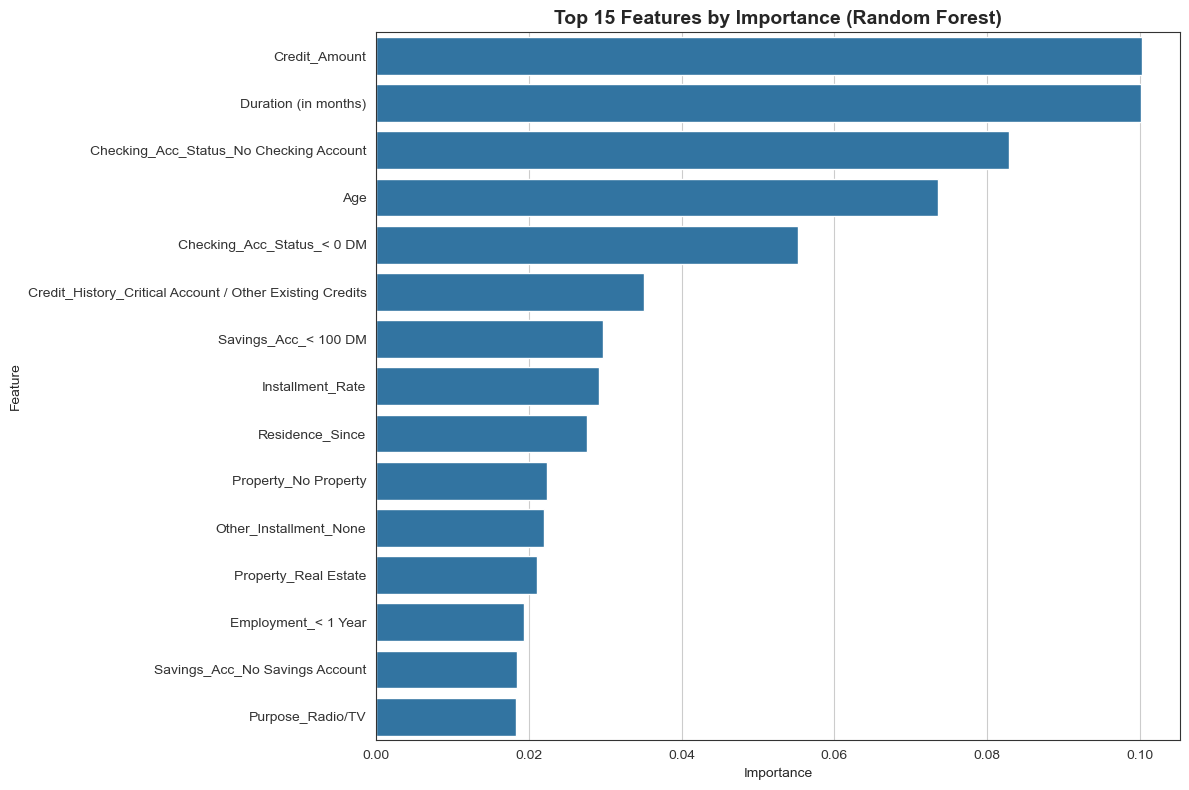

In [ ]:
# 3. Random Forest Classifier with Grid Search
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print(f"\nBest Random Forest parameters: {grid_search_rf.best_params_}")
best_rf = grid_search_rf.best_estimator_
rf_metrics = evaluate_model(best_rf, X_test, y_test, "Random Forest (Optimized)")

# Feature importance for Random Forest
if hasattr(best_rf, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Features by Importance (Random Forest)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()



**Key Takeaways:**
- **Random Forest outperforms both Baseline and KNN models.**
- **Bad Credit Recall improved to 59%**, meaning the model detects **more defaulters**.
- **Balanced performance** with **good precision and recall trade-off**.

The **Random Forest model** provides insight into which features contribute most to predicting **credit standing**.

**Key Takeaways:**
- **Credit Amount and Loan Duration** are the **two most important predictors** of credit risk.
- **Checking Account Status (No Account or Negative Balance)** strongly correlates with credit standing.
- **Younger applicants and those with poor credit history** tend to have worse credit standing.


### Discussion

<Figure size 1200x600 with 0 Axes>

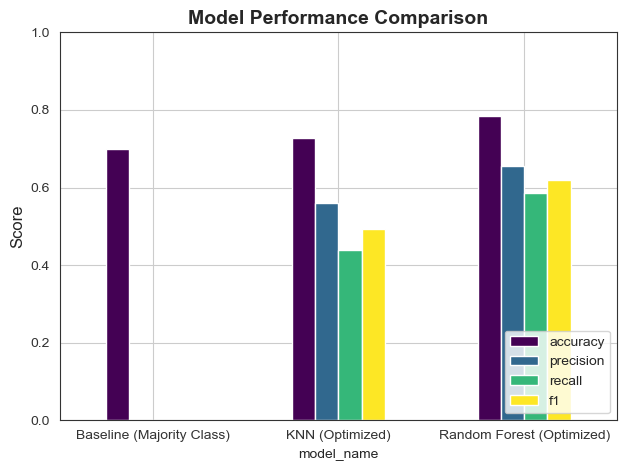

In [ ]:
# Compare model performance
models_comparison = pd.DataFrame([baseline_metrics, knn_metrics, rf_metrics])
models_comparison = models_comparison.set_index('model_name')

plt.figure(figsize=(12, 6))
models_comparison[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', colormap='viridis')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In our analysis, we evaluated three models: a Dummy Classifier, a k-Nearest Neighbors (k-NN) model, and a Random Forest model, to predict credit risk using the Statlog (German Credit Data) dataset. Each model's performance was assessed using key metrics: accuracy, precision, recall, F1 score, and false negative count. We also consider the false negative count in our analysis since we believe it's crucial to minimize the false negative count when it comes to financial reliability.

#### Dummy Classifier Performance:
- **Purpose**: The Dummy Classifier serves as a baseline, predicting the majority class without learning from the data.
- **Metrics**:
  - **Recall, Precision, and F1 Score**: These metrics are typically low for the Dummy Classifier, as it fails to identify minority class instances (bad credit risks) effectively.
  - **Accuracy**: While it might show reasonable accuracy in imbalanced datasets, this is misleading as it doesn't reflect true predictive capability.

#### k-Nearest Neighbors (k-NN) Performance:
- **Purpose**: The k-NN model is a simple, instance-based learning algorithm that classifies data points based on the majority class of their nearest neighbors.
- **Metrics**:
  - **Recall**: k-NN can achieve better recall than the Dummy Classifier by considering the local structure of the data, but it may still struggle with imbalanced datasets.
  - **Precision**: Precision can vary depending on the choice of `k` and the distance metric, but it generally improves over the Dummy Classifier.
  - **F1 Score**: The F1 score for k-NN is typically higher than that of the Dummy Classifier, indicating a better balance between precision and recall.
  - **Accuracy**: k-NN often shows improved accuracy over the Dummy Classifier, but it may not match the performance of more sophisticated models like Random Forests.

#### Random Forest Classifier Performance:
- **Purpose**: The Random Forest model is an ensemble method that builds multiple decision trees to improve prediction accuracy and robustness.
- **Metrics**:
  - **Recall**: Random Forests excel in recall, particularly for the minority class, by effectively capturing complex patterns in the data.
  - **Precision**: It also achieves high precision, reducing false positives and ensuring reliable predictions.
  - **F1 Score**: The F1 score is significantly higher for Random Forests, reflecting its superior ability to balance precision and recall.
  - **Accuracy**: Random Forests typically achieve the highest accuracy among the models tested, providing a comprehensive and reliable classification.

#### Comparison:
- **Dummy Classifier**: Serves as a baseline with limited predictive power, primarily due to its simplistic approach.
- **k-NN**: Offers improvements over the Dummy Classifier by leveraging local data structures, but its performance is sensitive to parameter choices and data imbalance.
- **Random Forest**: Outperforms both the Dummy Classifier and k-NN by providing a robust, accurate, and balanced classification, making it the preferred choice for credit risk assessment.

These findings highlight the importance of selecting appropriate models for credit risk prediction. While k-NN offers some improvements over a baseline, the Random Forest model's ability to handle complex datasets and provide reliable predictions makes it the most effective tool for this task.

### References

1. Basel Committee on Banking Supervision. (2001). *Principles for the Management of Credit Risk*. Bank for International Settlements. https://www.bis.org/publ/bcbs75.pdf  
2. Lessmann, S., Baesens, B., Seow, H.V., & Thomas, L.C. (2015). *Benchmarking state-of-the-art classification algorithms for credit scoring*. *Journal of the Operational Research Society*, 66(6), 740-755. https://doi.org/10.1016/j.ejor.2015.05.030  
3. Kuhn, M., & Johnson, K. (2013). *Applied Predictive Modeling*. Springer. https://doi.org/10.1007/978-1-4614-6849-3  
4. Tukey, J. W. (1977). *Exploratory Data Analysis*. Addison-Wesley. ISBN: 978-0201076165 
5. Statlog (German Credit Data) Dataset. Retrieved from: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data
